### <center>Calculating canopy biomass using LiDAR-derived canopy height models</center>

#### Adapted from: https://www.neonscience.org/resources/learning-hub/tutorials/calc-biomass-py

In [1]:
import os, sys
from osgeo import gdal
from osgeo import osr, ogr
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
%matplotlib inline 

#Import biomass specific libraries
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

In [2]:
# store data_path as S:\Zack\Imagery\Hazelnut\ArcGIS_Pro_Hazelnut_Biomass_Estimation\BiomassEstimation
data_path = r'S:/Zack/Imagery/Hazelnut/ArcGIS_Pro_Hazelnut_Biomass_Estimation/'
os.chdir(data_path)


In [3]:
#Define a function to plot a raster band
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [4]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [5]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + (metadata['array_cols'] * mapinfo[1])
    metadata['ext_dict']['yMin'] = mapinfo[3] + (metadata['array_rows'] * mapinfo[5])
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} # make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,
                                                     metadata['array_cols'],
                                                     metadata['array_rows']).astype(np.float64)
        if metadata['scaleFactor'] is not None:
            array = array/metadata['scaleFactor']
        return array, metadata

    else:
        print('More than one band ... function only set up for single band data')

In [6]:
def crown_geometric_volume_pct(tree_data,min_tree_height,pct):
    p = np.percentile(tree_data, pct)
    tree_data_pct = [v if v < p else p for v in tree_data]
    crown_geometric_volume_pct = np.sum(tree_data_pct - min_tree_height)
    return crown_geometric_volume_pct, p

In [7]:
def get_predictors(tree,chm_array, labels):
    indexes_of_tree = np.asarray(np.where(labels==tree.label)).T
    tree_crown_heights = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    
    full_crown = np.sum(tree_crown_heights - np.min(tree_crown_heights))
    
    crown50, p50 = crown_geometric_volume_pct(tree_crown_heights,tree.min_intensity,50)
    crown60, p60 = crown_geometric_volume_pct(tree_crown_heights,tree.min_intensity,60)
    crown70, p70 = crown_geometric_volume_pct(tree_crown_heights,tree.min_intensity,70)
        
    return [tree.label,
            np.float64(tree.area),
            tree.major_axis_length,
            tree.max_intensity,
            tree.min_intensity, 
            p50, p60, p70,
            full_crown, 
            crown50, crown60, crown70]

In [8]:
chm_file = os.path.join(data_path,'Rosemount_LeafOn_CHM_forBiomass_normalized.tif')
chm_file

'S:/Zack/Imagery/Hazelnut/ArcGIS_Pro_Hazelnut_Biomass_Estimation/Rosemount_LeafOn_CHM_forBiomass_normalized.tif'

In [9]:
#Get info from chm file for outputting results
chm_name = os.path.basename(chm_file)

In [10]:
chm_array, chm_array_metadata = raster2array(chm_file)

c:\Users\zack\anaconda3\envs\CanopyBiomass\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


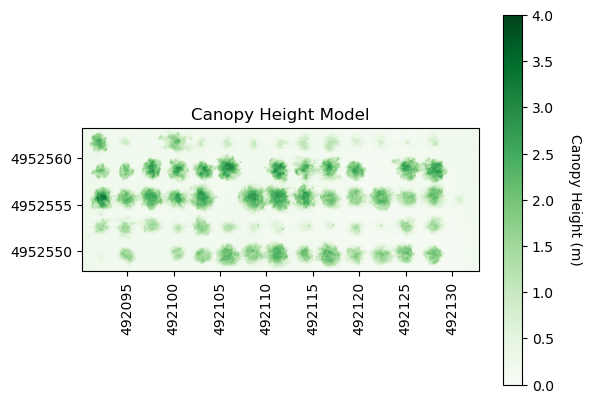

In [11]:
#Plot the original CHM
plt.figure(1)

#Plot the CHM figure
plot_band_array(chm_array,chm_array_metadata['extent'],
                'Canopy Height Model',
                'Canopy Height (m)',
                'Greens',[0, 4])
# x-min is the second value in chm_array_metadata['extent'], xmax is 
plt.savefig(os.path.join(data_path,chm_name.replace('.tif','.png')),dpi=300,orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)

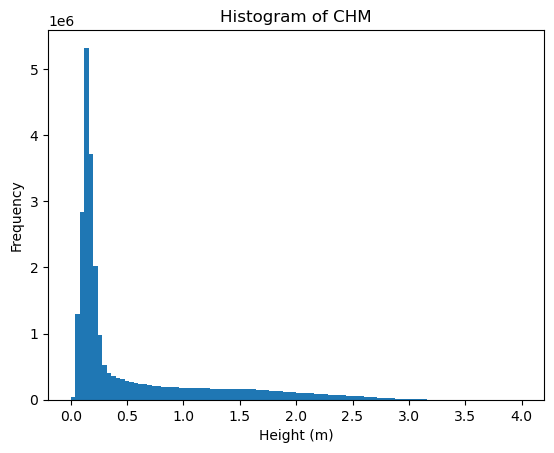

In [12]:
# plot histogram of chm_array
plt.figure(2)
plt.hist(chm_array.flatten(), bins=100, range=(0,4))
plt.title('Histogram of CHM')
plt.xlabel('Height (m)')
plt.ylabel('Frequency')
plt.savefig(os.path.join(data_path,chm_name.replace('.tif','_histogram.png')),dpi=300,orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)

In [13]:
#Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array,2,mode='constant',cval=0,truncate=2.0)
chm_array_smooth[chm_array==0] = 0 

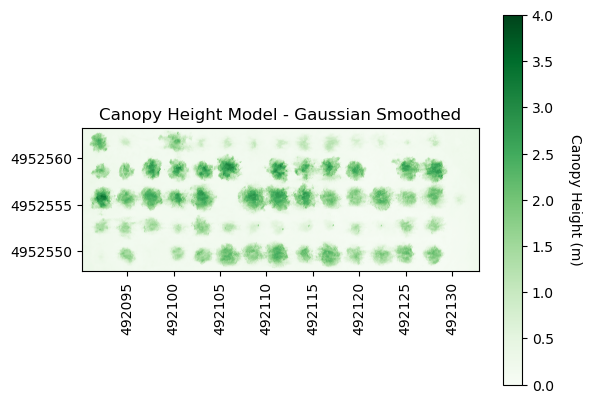

In [14]:
#Plot the original CHM
plt.figure(1)

#Plot the CHM figure
plot_band_array(chm_array_smooth,chm_array_metadata['extent'],
                'Canopy Height Model - Gaussian Smoothed',
                'Canopy Height (m)',
                'Greens',[0,4])
plt.savefig(os.path.join(data_path,chm_name.replace('.tif','_smooth.png')),dpi=300,orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)

In [15]:
#Save the smoothed CHM
array2raster(os.path.join(data_path,'chm_filter.tif'),
             (chm_array_metadata['ext_dict']['xMin'],chm_array_metadata['ext_dict']['yMax']),
             1,-1,np.array(chm_array_smooth,dtype=float),32611)

Text(0, 0.5, 'Northing (m)')

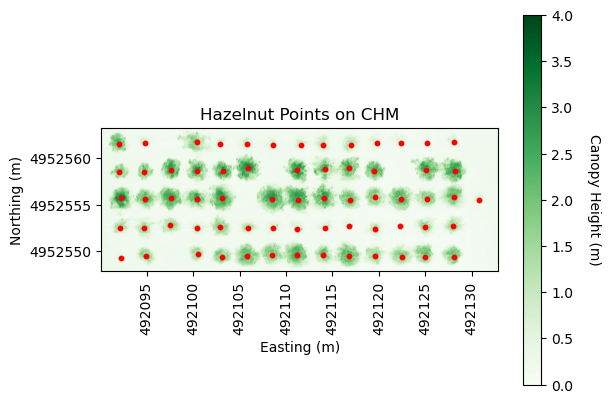

In [16]:
# Load shapefile from "S:\Zack\Imagery\Hazelnut\ArcGIS_Pro_Hazelnut_Biomass_Estimation\Rosemount_LeafOn_HazelnutPoints_forBiomass.shp" as ndarray
shapefile_path = os.path.join(data_path,'Rosemount_LeafOn_HazelnutPoints_forBiomass.shp')

# load shapefile object from shapefile_path
shapefile = ogr.Open(shapefile_path)

# convert shapefile to ndarray
lyr = shapefile.GetLayer()
points = []
for feat in lyr:
    geom = feat.GetGeometryRef()
    x = geom.GetX()
    y = geom.GetY()
    points.append([x,y])
# points float64 ndarray
points = np.array(points).astype(np.float64)

# plot the smoothed chm with the points
plt.figure(1)
plot_band_array(chm_array_smooth,chm_array_metadata['extent'],
                'Canopy Height Model - Gaussian Smoothed',
                'Canopy Height (m)',
                'Greens',[0,4])
plt.scatter(points[:,0],points[:,1],c='r',s=10)
plt.title('Hazelnut Points on CHM')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

In [17]:
local_maxi = peak_local_max(chm_array_smooth,
                            threshold_abs=0.4) # footprint is ~size (m) of smallest shrub


In [18]:
local_maxi

array([[1485,  420],
       [1492,  446],
       [1470,  430],
       ...,
       [2836, 2370],
       [2904, 1122],
       [2006,  990]], dtype=int64)

In [19]:
local_maxi.astype(int)

array([[1485,  420],
       [1492,  446],
       [1470,  430],
       ...,
       [2836, 2370],
       [2904, 1122],
       [2006,  990]])

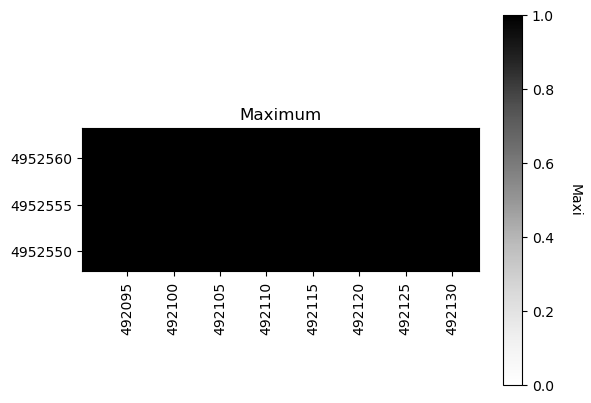

In [20]:
#Plot the local maximums
plt.figure(2)
plot_band_array(local_maxi.astype(int),chm_array_metadata['extent'],
                'Maximum',
                'Maxi',
                'Greys',
                [0, 1])

plt.savefig(data_path+chm_name[0:-4]+ '_Maximums.png',
            dpi=300,orientation='landscape',
            bbox_inches='tight',pad_inches=0.1)

array2raster(data_path+'maximum.tif',
             (chm_array_metadata['ext_dict']['xMin'],chm_array_metadata['ext_dict']['yMax']),
             1,-1,np.array(local_maxi,dtype=np.float64),32611)

In [21]:
#Identify all the maximum points
markers = ndi.label(local_maxi)[0]

In [22]:
#Create a CHM mask so the segmentation will only occur on the trees
chm_mask = chm_array_smooth
chm_mask[chm_array_smooth != 0] = 1

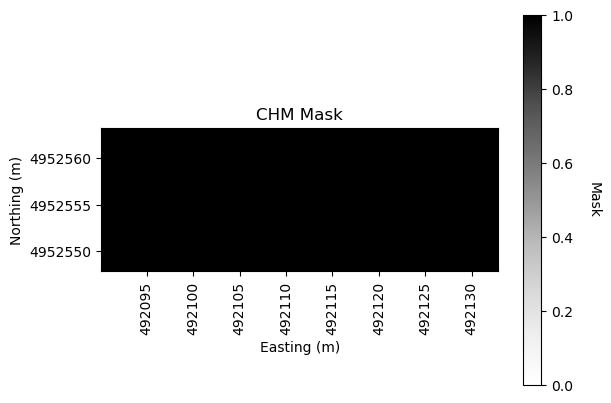

In [23]:
# plot the chm mask on the smoothed chm
plt.figure(1)
plot_band_array(chm_mask,chm_array_metadata['extent'],
                'Canopy Height Model Mask',
                'Mask',
                'Greys',
                [0, 1])
plt.title('CHM Mask')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.savefig(data_path+chm_name[0:-4]+ '_Mask.png',
            dpi=300,orientation='landscape',
            bbox_inches='tight',pad_inches=0.1)

In [25]:
# Perform watershed segmentation
markers = markers[""].reshape(chm_array_smooth.shape)
labels = watershed(chm_array_smooth, markers, mask=chm_mask)
labels_for_plot = labels.copy()
labels_for_plot = np.array(labels_for_plot, dtype=np.float64)
labels_for_plot[labels_for_plot == 0] = np.nan
max_labels = np.max(labels)

ValueError: cannot reshape array of size 128120 into shape (3087,8543)

In [ ]:
#Plot the segments      
plot_band_array(labels_for_plot,chm_array_metadata['extent'],
                'Crown Segmentation','Tree Crown Number',
                'Spectral',[0, max_labels])

plt.savefig(data_path+chm_name[0:-4]+'_Segmentation.png',
            dpi=300,orientation='landscape',
            bbox_inches='tight',pad_inches=0.1)

array2raster(data_path+'labels.tif',
             (chm_array_metadata['ext_dict']['xMin'],
              chm_array_metadata['ext_dict']['yMax']),
             1,-1,np.array(labels,dtype=float),32611)

In [ ]:
#Get the properties of each segment
tree_properties = regionprops(labels,chm_array)

In [ ]:
predictors_chm = np.array([get_predictors(tree, chm_array, labels) for tree in tree_properties])
X = predictors_chm[:,1:]
tree_ids = predictors_chm[:,0]